In [108]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sklearn

# Load data
data source: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

In [109]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a

--2023-08-25 18:20:07--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2329875 (2.2M)
Saving to: ‘a9a.9’

a9a.9               100%[===================>]   2.22M  1.63MB/s    in 1.4s    

2023-08-25 18:20:10 (1.63 MB/s) - ‘a9a.9’ saved [2329875/2329875]



In [110]:
!head a9a  # we have a sparse adta
# LibSVM format:  label  coordId:value coordId:value coordId:value coordId:value coordId:value

-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 5:1 7:1 14:1 19:1 39:1 40:1 51:1 63:1 67:1 73:1 74:1 76:1 78:1 83:1 
-1 3:1 6:1 17:1 22:1 36:1 41:1 53:1 64:1 67:1 73:1 74:1 76:1 80:1 83:1 
-1 5:1 6:1 17:1 21:1 35:1 40:1 53:1 63:1 71:1 73:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 18:1 19:1 39:1 40:1 52:1 61:1 71:1 72:1 74:1 76:1 80:1 95:1 
-1 3:1 6:1 18:1 29:1 39:1 40:1 51:1 61:1 67:1 72:1 74:1 76:1 80:1 83:1 
-1 4:1 6:1 16:1 26:1 35:1 45:1 49:1 64:1 71:1 72:1 74:1 76:1 78:1 101:1 
+1 5:1 7:1 17:1 22:1 36:1 40:1 51:1 63:1 67:1 73:1 74:1 76:1 81:1 83:1 
+1 2:1 6:1 14:1 29:1 39:1 42:1 52:1 64:1 67:1 72:1 75:1 76:1 82:1 83:1 
+1 4:1 6:1 16:1 19:1 39:1 40:1 51:1 63:1 67:1 73:1 75:1 76:1 80:1 83:1 


In [255]:
# see  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

@mem.cache
def get_data(filePath):
    data = load_svmlight_file(filePath)
    return data[0], data[1]

X, y = get_data("a9a")
# X=X[0:100,:]
# y=y[0:100]
print(type(X))
print(type(y))
# Convert CSR matrix to ndarray
X = X.toarray()
n, d =X.shape
print("We have %d samples, each has up to %d features"%(n,d))

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-a030203bdd4d>.get_data...
get_data('a9a')
_________________________________________________________get_data - 0.3s, 0.0min
<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>
We have 32561 samples, each has up to 123 features


In [99]:
# X[0,:].indices, X[0,:].data  # we should normalize data, but let's keep it for the assignment :)

AttributeError: ignored

# The Problem

## Hinge-square loss

$$
F_H(w) = \frac1n \sum_{i=1}^n \left(  \max \{ 0 ,y_i - w^T x_i \}  \right)^2
$$

$$
\nabla F_H(w) = \frac{1}{n}\sum_{i=1}^n \nabla F_{H, i} (w), \text{where} \quad \nabla F_{H, i} (w) =  \begin{cases}
2(w^T x_i - y_i)x_i, & y_i - w^T x_i \ge 0 \\
0, & \text{otherwise}
\end{cases} = 2(w^T x_i - y_i)x_i \cdot \mathbb{1}\{y_i - w^T x_i \ge 0\}
$$


## Logistic regression
$$
F_L(w) = \frac1n \sum_{i=1}^n \log(1+e^{-y_i x_i^T w})
$$
$$
\nabla F_L(w) = \frac{1}{n} \sum_{i=1}^n \nabla F_{L, i}(w), \quad \text{where} \quad \nabla F_{L, i} (w) = - \frac{y_i}{1+e^{y_i x_i^T w}} x_i
$$


# Task #1
For each function, decide if the function is convex, and also find a smoothness parameter $L$ such that

$$
 \forall w,w' \in R^d: \quad \| \nabla F(w) - \nabla F(w') \| \leq L \|w - w'\|
$$

### Hinge-square loss
The Hessian matrix of the hinge-square loss is
$$ \nabla^2 F_H (w) = \frac{2}{n} \sum_{i=1}^n x_i x_i^T \cdot \mathbb{1}\{y_i - w^T x_i \ge 0\} $$
It is obvious that the above matrix is positive semi-definite, therefore $F_H(w)$ is convex. The spectrum norm of $x_i x_i^T \cdot \mathbb{1}\{y_i - w^T x_i \ge 0\} $ is upper bounded by $||x_i||^2$. Therefore, a proper smooth parameter of the hinge-square loss is
$$
L = \frac{2}{n} \sum_{i=1}^n ||x_i||^2.
$$

### Logistic regression
The Hessian matrix of the logistic regression function is
$$
\nabla^2 F_L(w) = \frac{1}{n} \sum_{i=1}^n \frac{e^{y_i x_i^T w}}{(1 + e^{y_i x_i^T w})^2} x_i x_i^T
$$
Since $\nabla^2 F_L(w)$ is positive semidefinite, $F_L(w)$ is convex. Let $g(w) = \frac{e^{aw}}{(1+e^{aw})^2}$. Let $g'(w) = \frac{ae^{aw}[1 - e^{aw}]}{(1+ e^{aw})^3} = 0$ derive that $w^*=0$, together with $g''(w) < 0 $, we have $g(w) \le g(0) = \frac{1}{4}$. So we have
$$
\begin{aligned}
\nabla^2 F_L(w) & = \frac{1}{n} \sum_{i=1}^n \frac{e^{y_i x_i^T w}}{(1 + e^{y_i x_i^T w})^2} x_i x_i^T \\
& \preceq \frac{1}{4} \cdot \frac{1}{n} \sum_{i=1}^n x_i x_i^T
\end{aligned}
$$
Since the rank of $x_ix_i^T$ is 1, the spectrum norm of the symmetric matrix $x_i x_i^T$ is equal to the trace of $x_i x_i^T$, i.e., $||x_i||^2$. So we have
$$
\begin{aligned}
\nabla^2 F_L(w) \preceq \frac{1}{4} \cdot \frac{1}{n} \sum_{i=1}^n x_i x_i^T \preceq \frac{1}{4n} \sum_{i=1}^n \|x_i\|^2 I.
\end{aligned}
$$
Thus, a proper smooth parameter of the logistic regression is
$$ L= \frac{1}{4n} \sum_{i=1}^n \|x_i\|^2. $$

# Task #2
Implement (without for loops) following functions

In [195]:
np.random.seed(0)
w = np.random.randn(d)
def FH(X, y, w):
    n = len(y)
    loss_sum = 0

    for i in range(n):
        prediction = np.dot(w, X[i])
        loss = max(0, y[i] - prediction) ** 2
        loss_sum += loss
    return loss_sum/n

def gradFH(X, y, w):
    n = len(y)
    gradient_sum = np.zeros_like(w)

    for i in range(n):
        prediction = np.dot(w, X[i])
        if y[i] - prediction > 0:
            gradient_sum += -2 * (y[i] - prediction) * X[i]

    return gradient_sum / n


def FL(X, y, w):
    return np.mean(np.log(1 + np.exp(-y * X.dot(w))))

def gradFL(X, y, w):
    n = len(y)
    gradient = np.zeros_like(w)
    for i in range(n):
        prediction = np.dot(X[i], w)
        gradient += -y[i] * X[i] / (1 + np.exp(y[i] * prediction))
    return gradient / n


# Task #3
Implement gradient descent algorithm that will use the step-size $\gamma = \frac1L$ and run it for both function.
Then make two plots, 1 showing the evolution of $\{F_\cdot (w_t)\}$ and the second one (in y-log scale) showing $\{\| \nabla F_\cdot (w_t)\|^2\}$

In [196]:
np.random.seed(0)
# w_0 = np.random.randn(d) # initial point for the following tasks
# w_0 = np.zeros(d)



### Hinge-squared loss

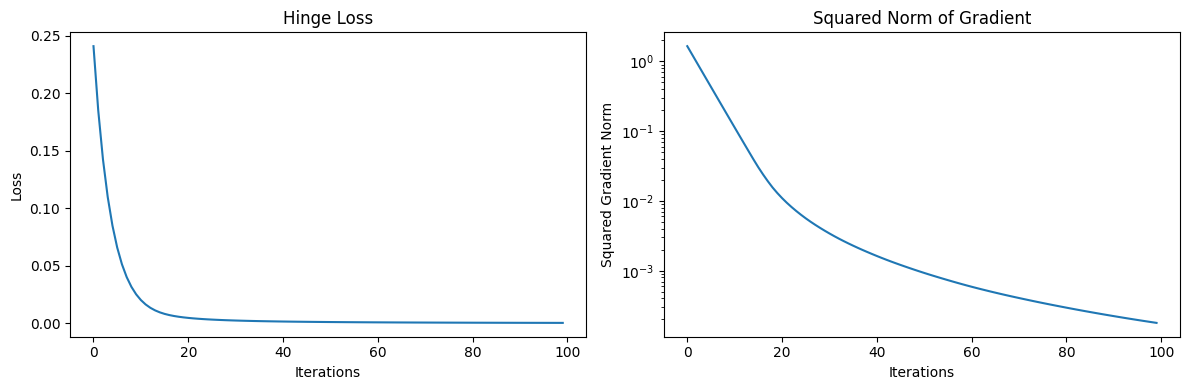

In [256]:


def hinge_gradient_descent(X, y, num_iterations):
    n, d = X.shape
    w = np.zeros(d)
    L = 2 / n * np.sum(np.linalg.norm(X, axis=1)**2)  # Lipschitz constant
    losses = []
    squared_grad_norms = []

    for _ in range(num_iterations):
        loss = FH(X, y, w)
        gradient = gradFH(X, y, w)
        grad_norm_sq = np.linalg.norm(gradient)**2

        w -= (1 / L) * gradient
        losses.append(loss)
        squared_grad_norms.append(grad_norm_sq)

    return w, losses, squared_grad_norms

num_iterations = 100

learned_w, losses, squared_grad_norms = hinge_gradient_descent(X, y, num_iterations)

# Plot the loss function and squared norm of gradient
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_iterations), losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Hinge Loss')

plt.subplot(1, 2, 2)
plt.semilogy(range(num_iterations), squared_grad_norms, label='Squared Gradient Norm')
plt.xlabel('Iterations')
plt.ylabel('Squared Gradient Norm')
plt.title('Squared Norm of Gradient')
plt.tight_layout()
plt.show()

## Logistic regression

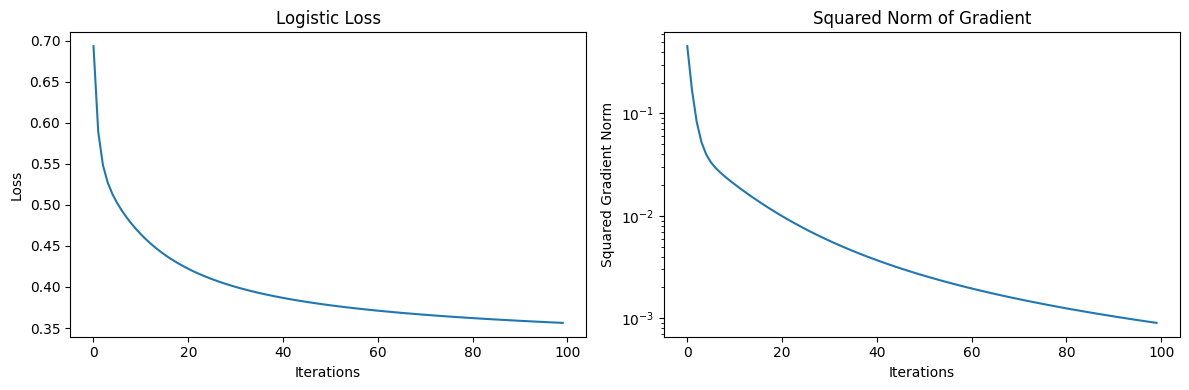

In [257]:
def logistic_gradient_descent(X, y, num_iterations):
    n, d = X.shape
    w = np.zeros(d)
    L = 1 / (4*n) * np.sum(np.linalg.norm(X, axis=1)**2)  # Lipschitz constant
    losses = []
    squared_grad_norms = []

    for _ in range(num_iterations):
        loss = FL(X, y, w)
        gradient = gradFL(X, y, w)
        grad_norm_sq = np.linalg.norm(gradient)**2

        w -= (1 / L) * gradient
        losses.append(loss)
        squared_grad_norms.append(grad_norm_sq)

    return w, losses, squared_grad_norms


num_iterations = 100

learned_w, losses, squared_grad_norms = logistic_gradient_descent(X, y, num_iterations)

# Plot the loss function and squared norm of gradient
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_iterations), losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Logistic Loss')

plt.subplot(1, 2, 2)
plt.semilogy(range(num_iterations), squared_grad_norms, label='Squared Gradient Norm')
plt.xlabel('Iterations')
plt.ylabel('Squared Gradient Norm')
plt.title('Squared Norm of Gradient')
plt.tight_layout()
plt.show()

# Task #4
Implement gradient descent algorithm that adaptive step-size strategy as discussed in first lecture, using sufficient decrease condition. Show how step-size is changing over-time for the two functions and give explanation for the observed behaviour.

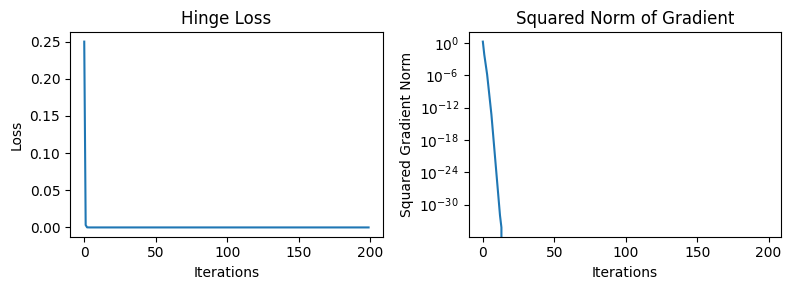

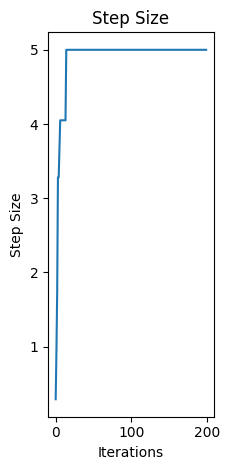

In [254]:


def hinge_gradient_descent(X, y, num_iterations):
    n, d = X.shape
    w = np.zeros(d)
    losses = []
    squared_grad_norms = []
    stepsizes = []

    for iteration in range(num_iterations):
        gradient = gradFH(X, y, w)

        new_loss = FH(X, y, w)
        losses.append(new_loss)
        grad_norm_sq = np.linalg.norm(gradient)**2
        squared_grad_norms.append(grad_norm_sq)

        step_size = 5
        while True:
            new_w = w - step_size * gradient
            if FH(X, y, new_w) <= new_loss - 0.5 * step_size * np.dot(gradient, gradient):
                break
            step_size *= 0.9  # Reduce step size

        w = new_w
        stepsizes.append(step_size)


    return w, losses, squared_grad_norms, stepsizes

num_iterations = 200

learned_w, losses, squared_grad_norms, stepsizes = hinge_gradient_descent(X, y, num_iterations)

# Plot the loss function, squared norm of gradient and step size
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(range(num_iterations), losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Hinge Loss')

plt.subplot(1, 3, 2)
plt.semilogy(range(num_iterations), squared_grad_norms, label='Squared Gradient Norm')
plt.xlabel('Iterations')
plt.ylabel('Squared Gradient Norm')
plt.title('Squared Norm of Gradient')
plt.tight_layout()
plt.show()

plt.subplot(1, 3, 3)
plt.plot(range(num_iterations), stepsizes, label='Step Size')
plt.xlabel('Iterations')
plt.ylabel('Step Size')
plt.title('Step Size')
plt.tight_layout()
plt.show()

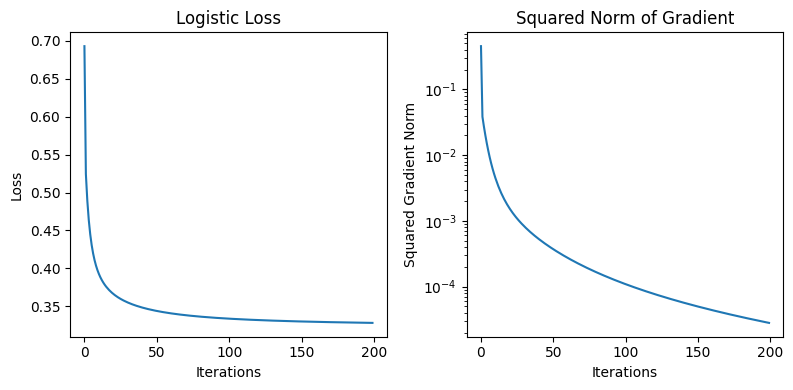

Text(0.5, 1.0, 'Step Size')

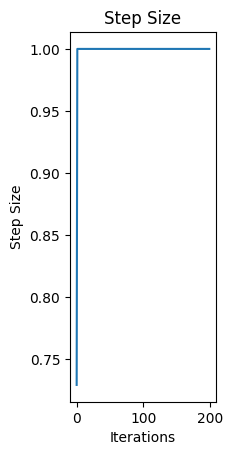

In [258]:


def logistic_gradient_descent(X, y, num_iterations):
    n, d = X.shape
    w = np.zeros(d)
    losses = []
    squared_grad_norms = []
    stepsizes = []

    for _ in range(num_iterations):
        gradient = gradFL(X, y, w)

        new_loss = FL(X, y, w)
        losses.append(new_loss)
        grad_norm_sq = np.linalg.norm(gradient)**2
        squared_grad_norms.append(grad_norm_sq)

        step_size = 1
        while True:
            new_w = w - step_size * gradient
            if FL(X, y, new_w) <= new_loss - 0.5 * step_size * np.dot(gradient, gradient):
                break
            step_size *= 0.9  # Reduce step size

        w = new_w
        stepsizes.append(step_size)


    return w, losses, squared_grad_norms, stepsizes

num_iterations = 200

learned_w, losses, squared_grad_norms, stepsizes = logistic_gradient_descent(X, y, num_iterations)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(num_iterations), losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Logistic Loss')

plt.subplot(1, 3, 2)
plt.semilogy(range(num_iterations), squared_grad_norms, label='Squared Gradient Norm')
plt.xlabel('Iterations')
plt.ylabel('Squared Gradient Norm')
plt.title('Squared Norm of Gradient')
plt.tight_layout()
plt.show()

plt.subplot(1, 3, 3)
plt.plot(range(num_iterations), stepsizes, label='Step Size')
plt.xlabel('Iterations')
plt.ylabel('Step Size')
plt.title('Step Size')

Explanation: The sufficient decrease condition checks whether the decrease in the objective function is sufficient given the current gradient and the chosen step size. If the sufficient decrease condition is satisfied, it means that the step size is reasonable and moves in the direction of decreasing the objective function. If the condition is not satisfied, the step size is reduced and the condition is rechecked.